**Fall 2024**
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

**University of Science and Technology, Zewail City**

####**Math 404, Linear and Non-linear Programming**

<br>

**<h1 align="center">Final Project</h3>**

**<h1 align="center">Tuning hyperparameters for Machine Learning models using Linear Programming Optimization</h3>**

**<h1 align="center">Bayesian Optimization of SVM</h3>**

***By:***

**Riham Mohamed 201-901-639**

**Hajar Alshafai 201-900-537**

**Verina Zarif 201-901-451**

---

# **3.4. Applying Bayesian Optimization on Hyperparameters of Support Vector Machine (SVM):**

#**Back-Ground Concept:**

**Bayesian optimization** is a type of sequential model-based optimization (SMBO) algorithm that enables us to enhance our sampling strategy for the subsequent experiment by utilizing the output of our prior iteration.


Building a posterior distribution of functions (a Gaussian process) that best characterizes the function we wish to optimize is how Bayesian optimization operates.

The posterior distribution gets better as the number of observations increases, increasing the algorithm's confidence in identifying which areas of parameter space are worthwhile to explore and which are not.


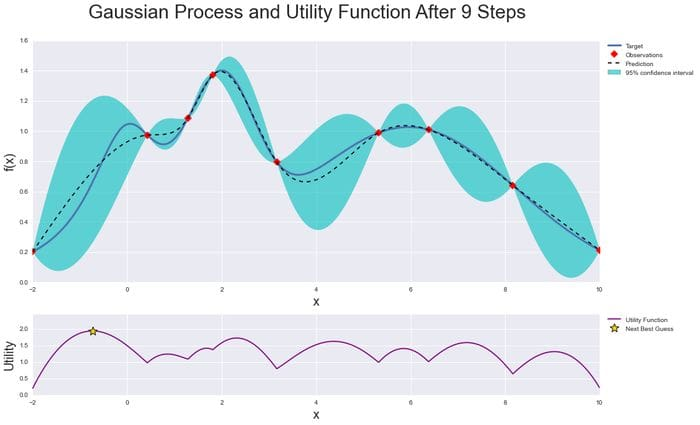

***
Visualising the previous graphs,

While **Iterating**, the algorithm takes into consideration its knowledge of the target function to balance its demands for exploration and exploitation.

The next point to be investigated is determined at each step by fitting a Gaussian Process to the known samples (points already examined) and use the posterior distribution in conjunction with an exploration method.

We can explore the parameter space more wisely and cut down on the amount of time needed to complete this operation by using Bayesian Optimization.
***

# **Installations:**

In [ ]:
%matplotlib inline
!apt-get install texlive-xetex
!apt-get install texlive-fonts-recommended
!apt-get install texlive-latex-base

# **Imports:**

In [ ]:
import numpy as np
import sklearn.gaussian_process as gp
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import matplotlib

# **Proplem Defination:**

We'll optimize:

*   The Penalization Parameter: $C$
*   The Kernel Parameter: $\gamma$

of a **Support Vector Machine**, with these specifictaions:
   
*   The loss function: the cross-validated area under the curve (AUC).

T o get the Minimum Optimal Loss - -> Highest Accuracy.
***

# **Acquisition Function:**

**Acquisition Function:**
To derive the extrema of the objective function, Bayesen optimization uses an Acquisition Function.

The choice of the Acquisition Function depends on the problem optimized.

It is assumed that the maximum value of the Acquisition Function is the maximum of the objective function. Due to that  effect the new goal is to maximize the Acquisition Function which is also equivalent to maximizing the objective function.


Different Acquisition Functions include Probability of improvement (PI), Expected improvement (EI) and GP upper confidence bound (GP-UCB).

**We chose to implement The Expected improvement (EI) Function:**


This function calculates the Expected Improvement (EI) acquisition function whicht is commonly used in Bayesian optimization to guide the selection of the next set of hyperparameters to evaluate.

In [ ]:
def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


Here's a breakdown of the function `expected_improvement`:

- **x**: An array-like object of shape `[n_samples, n_hyperparams]`, representing the points for which the expected improvement needs to be computed. These points are typically candidates for the next set of hyperparameters to evaluate.

- **gaussian_process**: A GaussianProcessRegressor object, which is a probabilistic model (Gaussian Process) trained on previously evaluated hyperparameters.

- **evaluated_loss**: A numpy array containing the values of the loss function for the previously evaluated hyperparameters.

- **greater_is_better**: A boolean flag indicating whether the goal is to maximize (True) or minimize (False) the loss function.

- **n_params**: An integer indicating the dimensionality of the hyperparameter space.

The function starts by reshaping the input `x` to be a 2D array with shape `(n_samples, n_params)`. Then, it uses the `predict` method of the Gaussian process to obtain the mean (`mu`) and standard deviation (`sigma`) of the predictive distribution at the points specified by `x`.

The Expected Improvement is then calculated based on these predicted mean and standard deviation values. The formula involves the cumulative distribution function (`norm.cdf`) and the probability density function (`norm.pdf`) of a standard normal distribution.

The `scaling_factor` is used to adjust the direction of improvement depending on whether the goal is to maximize or minimize the loss function. The resulting Expected Improvement values are then negated (`return -1 * expected_improvement`) because, in Bayesian optimization, the goal is often to minimize the negative of the objective function.

Note: The `with np.errstate(divide='ignore')` is used to handle cases where `sigma` equals zero to avoid division by zero errors. If `sigma` is zero, the corresponding `expected_improvement` values are set to zero.

# **Sampling Next HyperParameter:**

The Function **sample_next_hyperparameter** selects the next hyperparameter to evaluate in order to maximize the Objective Function:

In [ ]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

Here's a breakdown of the function  `sample_next_hyperparameter`:

- **acquisition_func**: It is a function that represents the acquisition function to be optimized. The acquisition function guides the selection of the next hyperparameter to evaluate.

- **gaussian_process**: It is a GaussianProcessRegressor object, which is essentially a probabilistic model (Gaussian Process) trained on previously evaluated hyperparameters.

- **evaluated_loss**: A numpy array containing the values of the loss function for the previously evaluated hyperparameters.

- **greater_is_better**: A boolean flag indicating whether the goal is to maximize (True) or minimize (False) the loss function.

- **bounds**: A tuple specifying the lower and upper bounds for each hyperparameter. For example, `bounds=(0, 10)` means that each hyperparameter should be within the range [0, 10].

- **n_restarts**: The number of times to run the minimizer (L-BFGS-B) with different starting points. This helps in avoiding local minima.

The function initializes with a default best acquisition value (`best_acquisition_value = 1`) and iterates over a set of random starting points (`np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params))`). For each starting point, it uses the L-BFGS-B optimization method (`minimize`) to find the minimum (or maximum) of the acquisition function, and the best hyperparameter is updated if a new minimum (maximum) is found.

Finally, the function returns the best hyperparameter found during the search. This hyperparameter is the one that, according to the acquisition function, is expected to yield the most valuable information about the objective function.

# **Bayesian Optimisation:**

This function implements Bayesian optimization, a probabilistic model-based optimization algorithm that is particularly useful for optimizing expensive-to-evaluate black-box functions:

In [ ]:
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

Here's a breakdown of the this function `bayesian_optimisation`:

- **n_iters**: Integer. Number of iterations to run the search algorithm.

- **sample_loss**: Function. The objective function (loss function) to be optimized.

- **bounds**: Array-like, shape = [n_params, 2]. Lower and upper bounds on the parameters of the function `sample_loss`.

- **x0**: Array-like, shape = [n_pre_samples, n_params]. Array of initial points to sample the loss function for. If None, randomly samples from the loss function.

- **n_pre_samples**: Integer. If `x0` is None, it samples `n_pre_samples` initial points from the loss function.

- **gp_params**: Dictionary. Dictionary of parameters to pass on to the underlying Gaussian Process (GP). If None, default parameters are used.

- **random_search**: Integer. Flag that indicates whether to perform random search or L-BFGS-B optimization over the acquisition function.

- **alpha**: Double. Variance of the error term of the GP.

- **epsilon**: Double. Precision tolerance for floats.

The function initializes lists `x_list` and `y_list` to store the observed hyperparameter values and corresponding loss values. It then samples initial points based on whether `x0` is provided or not.

The Gaussian Process (`model`) is created using either the provided parameters in `gp_params` or default parameters if `gp_params` is None.

The main loop runs for `n_iters` iterations. In each iteration, the GP model is fit to the observed data (`xp` and `yp`). It then samples the next hyperparameter either through random search (`x_random`) or by optimizing the Expected Improvement (EI) acquisition function using `sample_next_hyperparameter`.

The function checks for duplicates in the sampled hyperparameters. If a duplicate is found, it randomly samples a new query point.

The loss for the new set of parameters is computed using the `sample_loss` function, and the lists `x_list` and `y_list` are updated.

Finally, the function returns the observed hyperparameter values (`xp`) and the corresponding loss values (`yp`).

# **Visulization Functions:**

## ***plot_iteration:***

In [ ]:
def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
    """ plot_iteration

    Plots a line plot (1D) or heatmap (2D) of the estimated loss function and expected
    improvement acquisition function for each iteration of the Bayesian search algorithm.

    Arguments:
    ----------
        first_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the first parameter.
        sampled_params: array-like, shape = [n_points, n_params]
            Points for which the value of the loss function is computed.
        sampled_loss: function.
            Values of the loss function for the parameters in `sampled_params`.
        first_iter: int.
            Only plot iterations after the `first_iter`-th iteration.
        alpha: float
            Variance of the error term in the GP model.
        greater_is_better: boolean
            Boolean indicating whether we want to maximise or minimise the loss function.
        true_y: array-like, shape = [n, 1] or None
            Array containing the true value of the loss function. If None, the real loss
            is not plotted. (1-dimensional case)
        second_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the second parameter, in case
            of a heatmap.
        param_dims_to_plot: list of length 2
            List containing the indices of `sampled_params` that contain the first and
            second parameter.
        optimum: array-like [1, n_params].
            Maximum value of the loss function.
    """
    import sklearn.gaussian_process as gp

    # Create the GP
    kernel = gp.kernels.Matern()
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)

            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)

            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot], sampled_loss, mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        if filepath is not None:
            plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')

##***1D-plot_loss:***

In [ ]:
def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2
Skip to main content


##***2D-plot_loss:***

In [ ]:
def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("C")
    ax1.set_ylabel("gamma")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("C")
    ax2.set_ylabel("gamma")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='gold', s=150)

    return fig, ax1, ax2

# **_main Implementation Starts Here:**

## **Generating Synthetic Data by  `make_classification` function from scikit-learn**




In [ ]:
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

## **Defination of a Loss Function:**


In [ ]:
def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

## **Generation of $C$ and $\gamma$:**

In [ ]:
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# The cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

# Calculating the Loss for each parameter
real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 0.16666667, -2.15789474])

In [ ]:
matplotlib.rcParams['text.usetex'] = False

In [ ]:
rc('text', usetex=False)
C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma')
plt.show()

## **Bayesian Optimisation Calling:**

We'll assume a [Matern](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) kernel as the covariance function. Although we skim over the selection of the kernel here, in general the behaviour of the algorithm is dependent on the choice of the kernel. Using a Matern kernel, with the default parameters, means we implicitly assume the loss $f$ is at least once differentiable.

In [ ]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=30,
                               sample_loss=sample_loss,
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

# **4. Results:**

The animation below shows the sequence of points selected, if we run the Bayesian optimization algorithm in this setting. The star shows the value of $C$ and $\gamma$ that result in the largest value of cross-validated AUC.

<ipython-input-40-b1b56babf11c>:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)


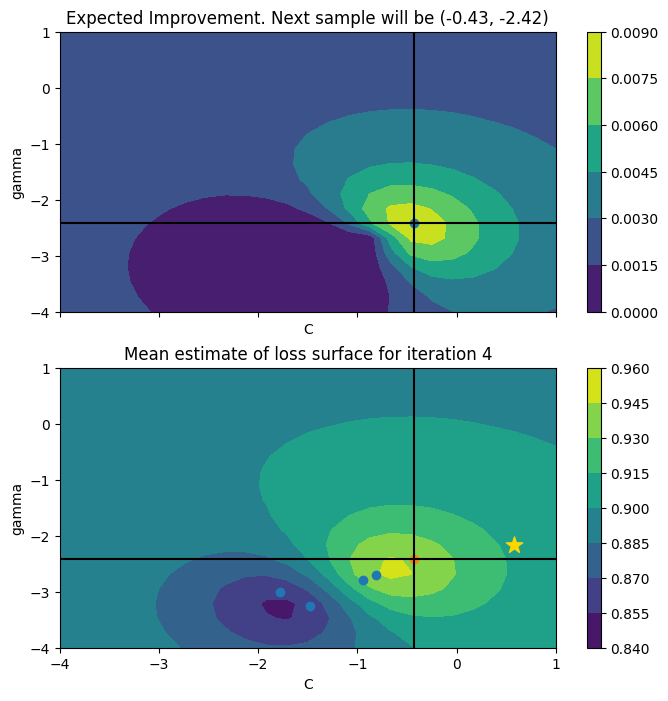

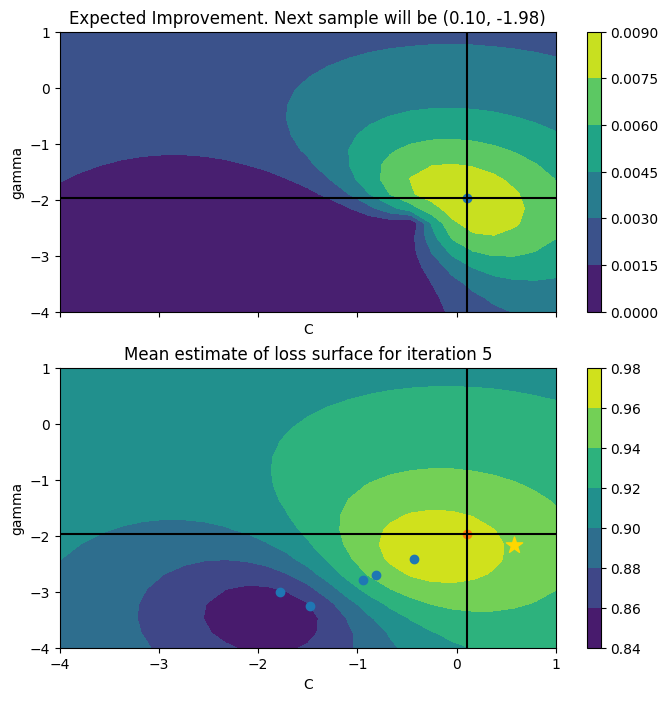

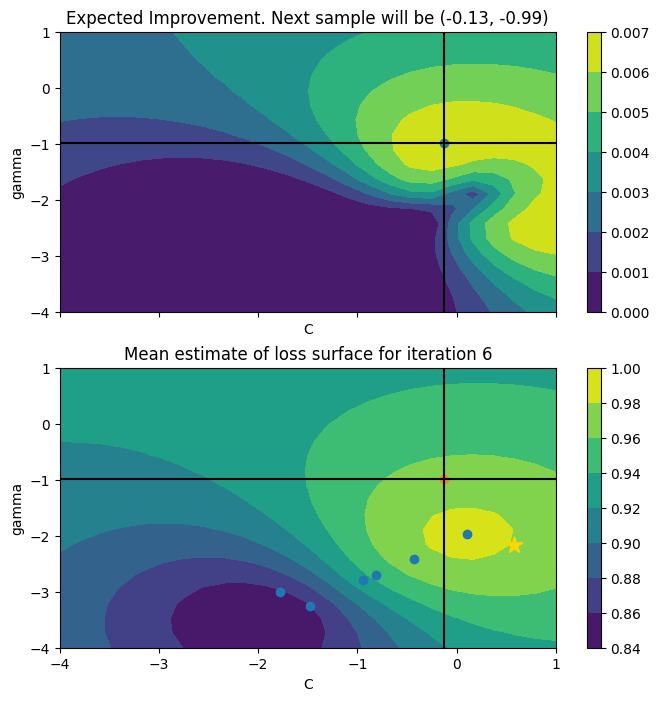

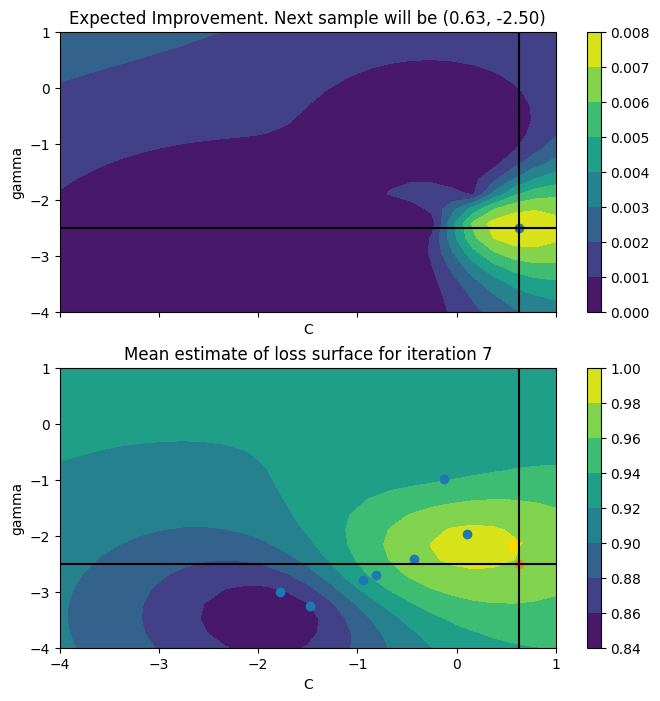

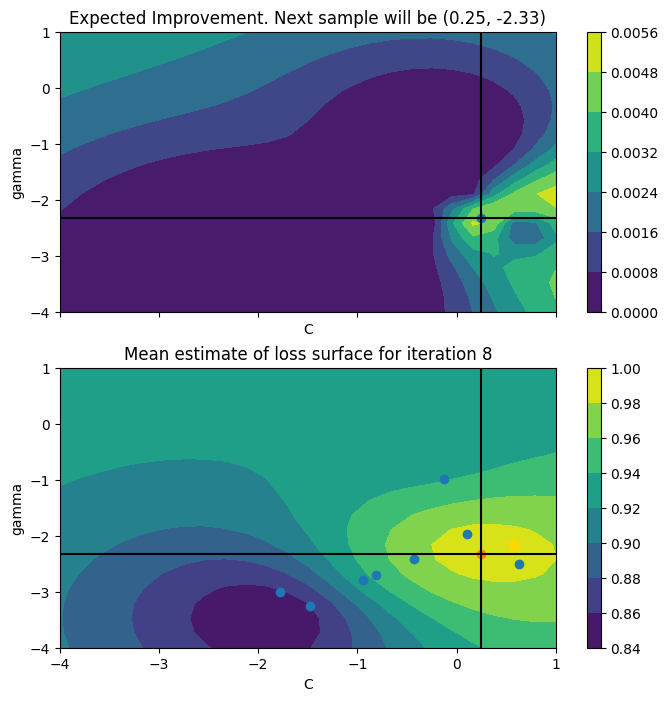

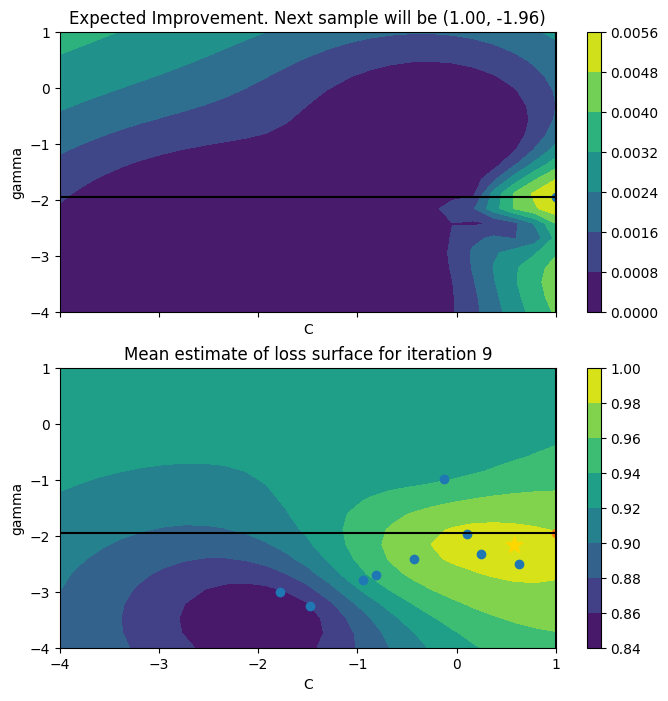

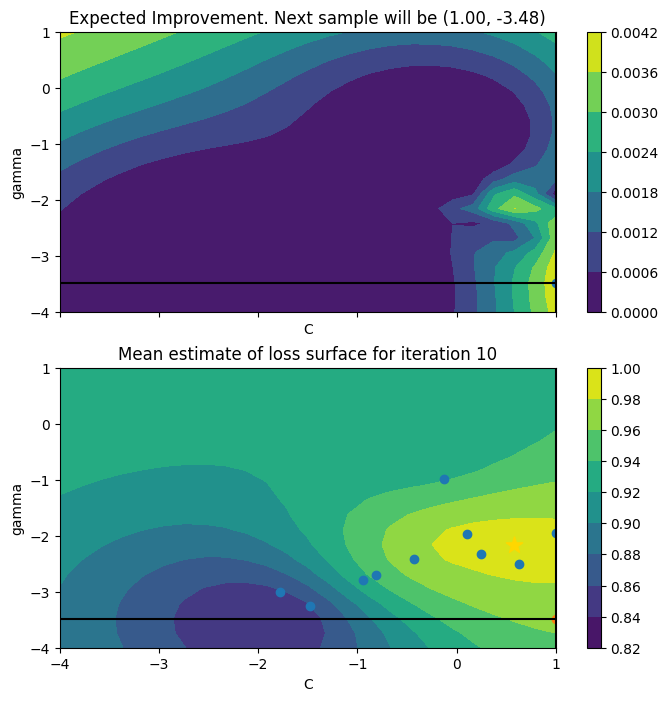

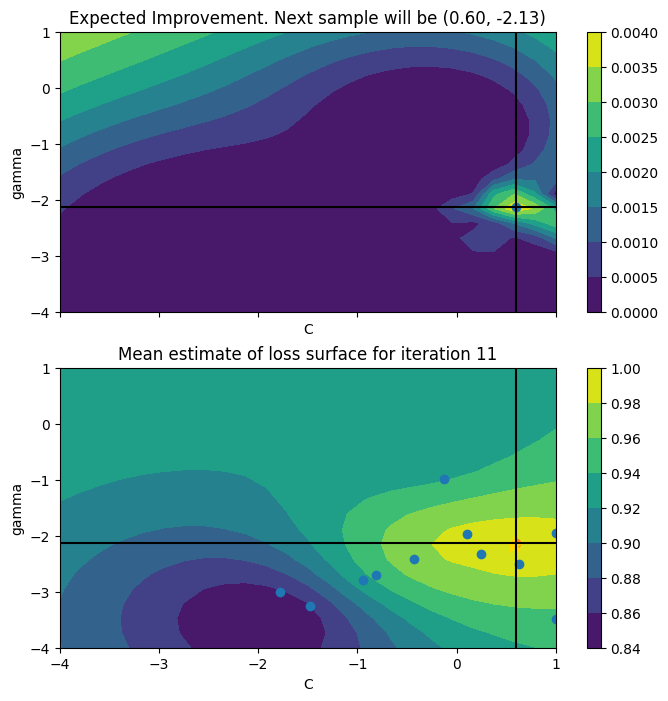

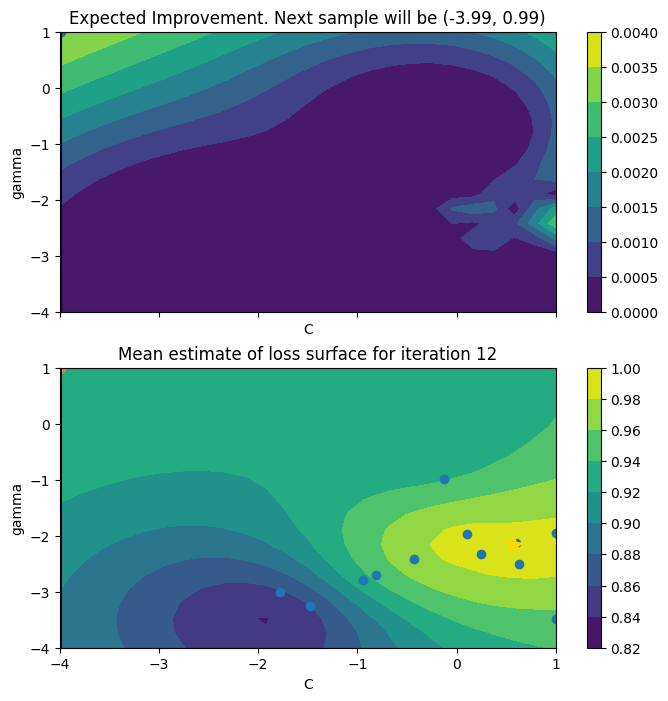

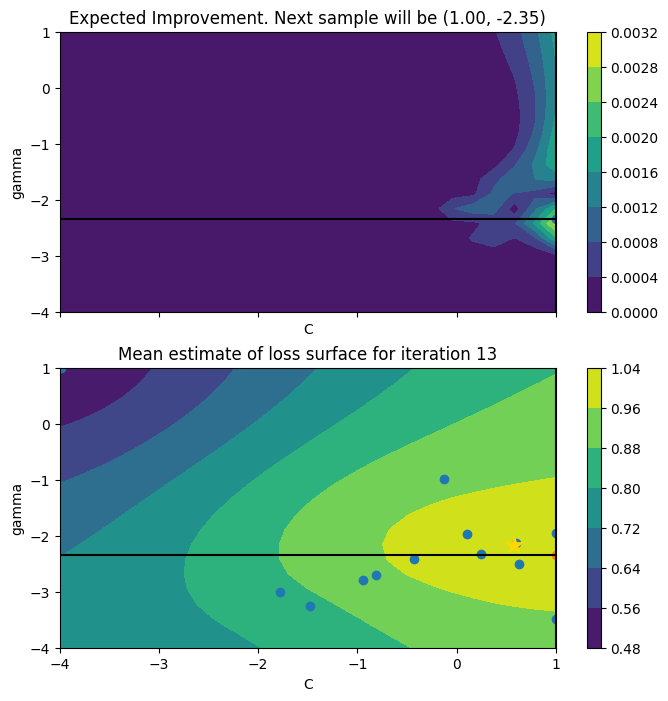

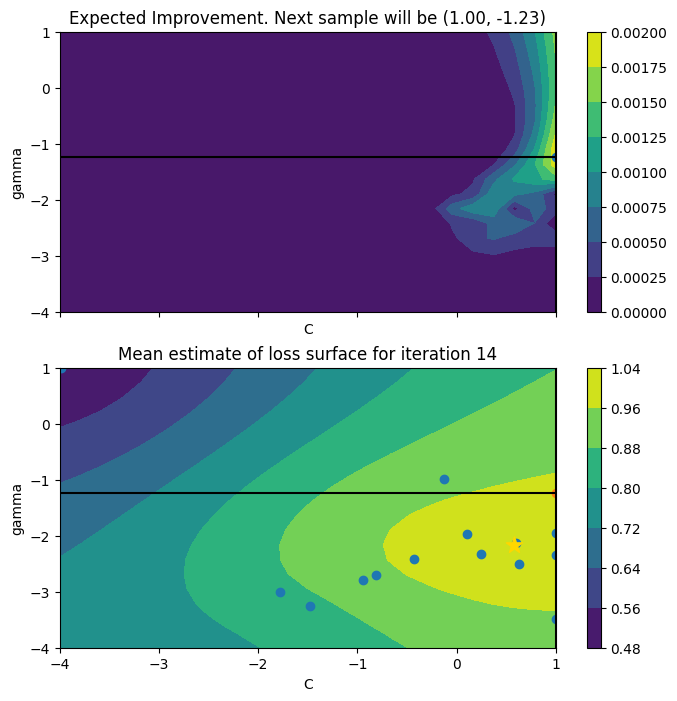

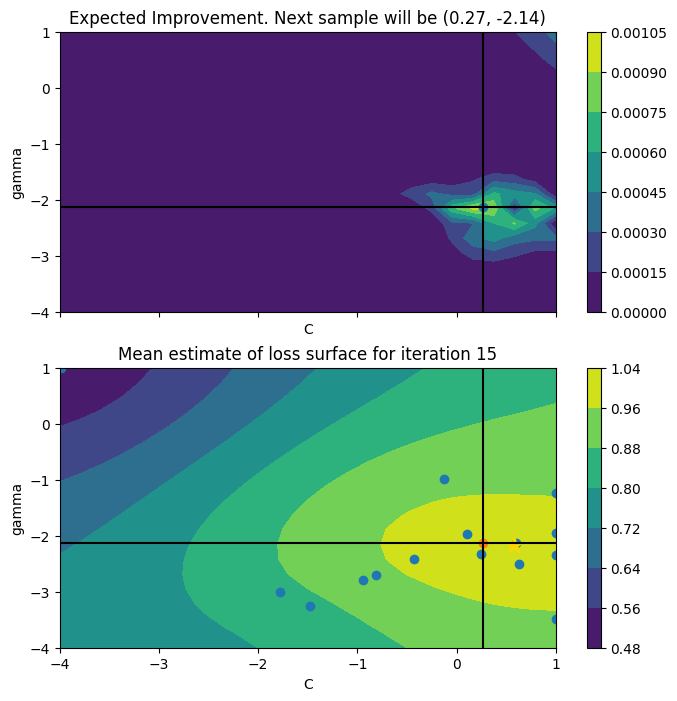

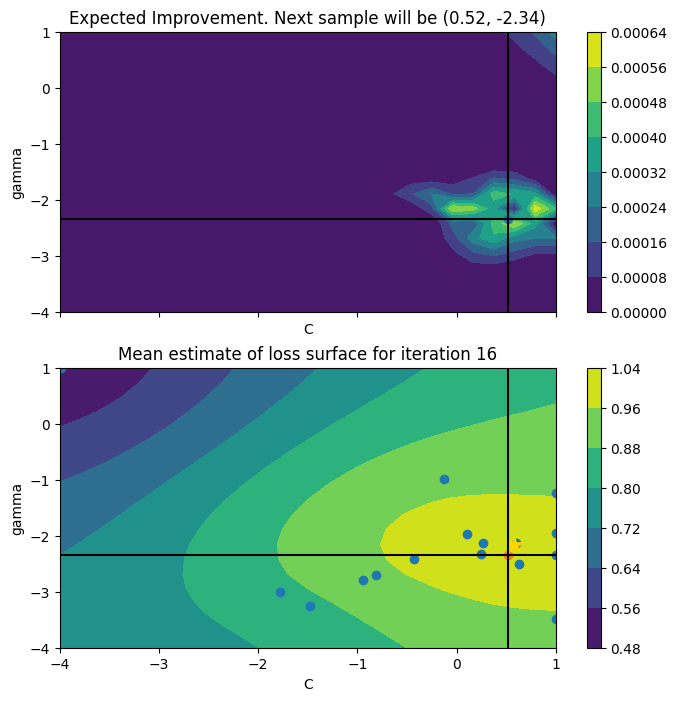

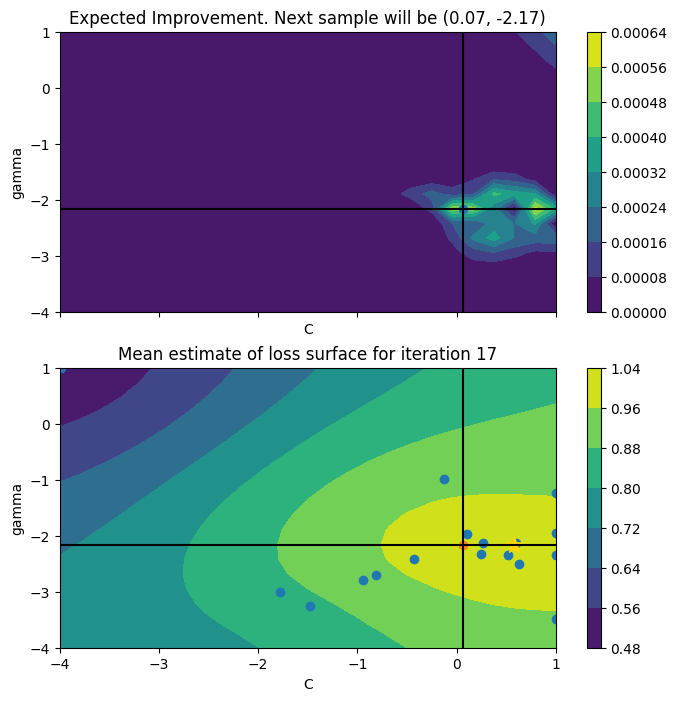

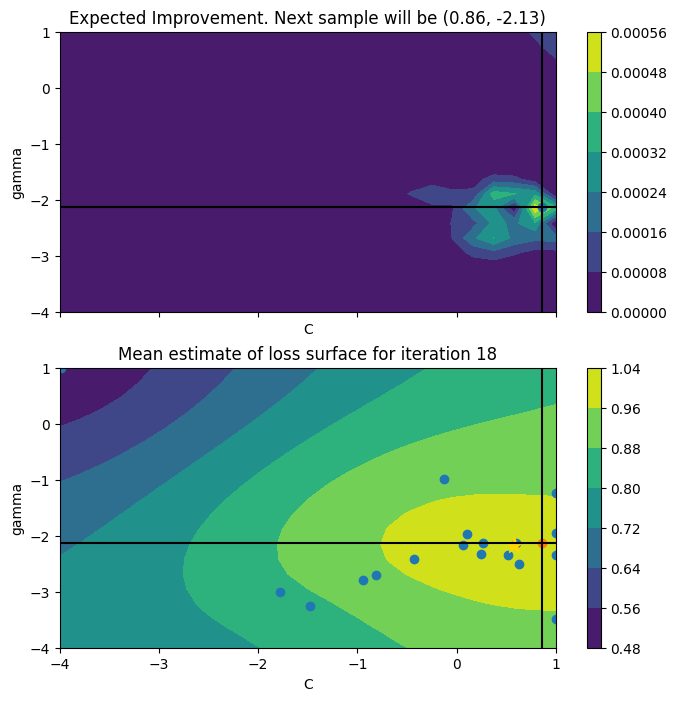

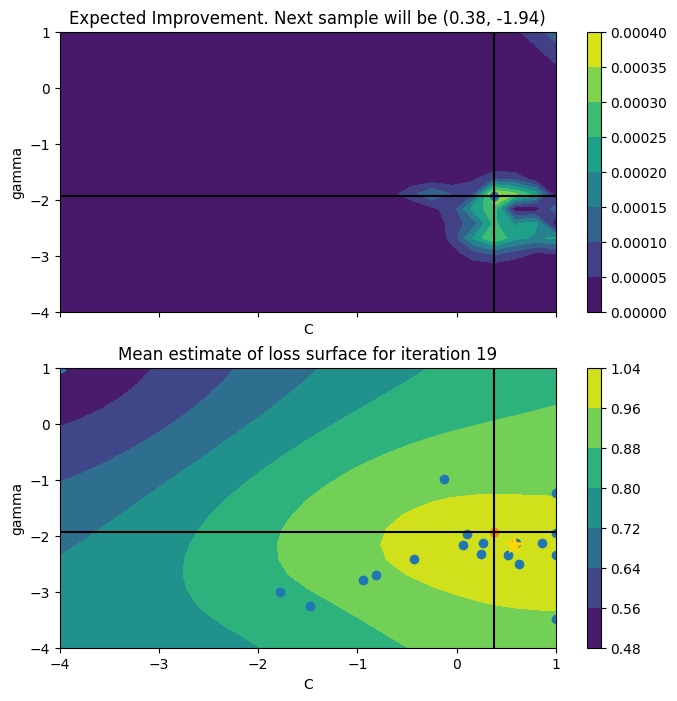

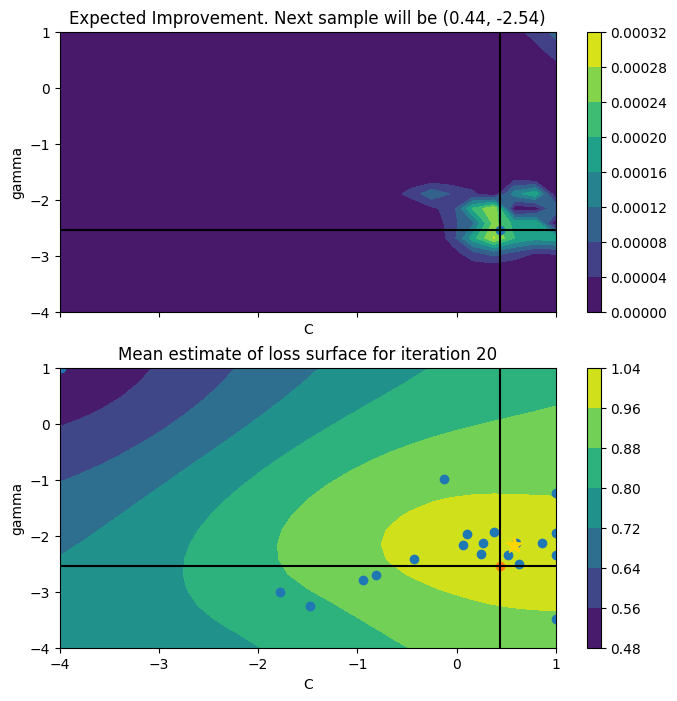

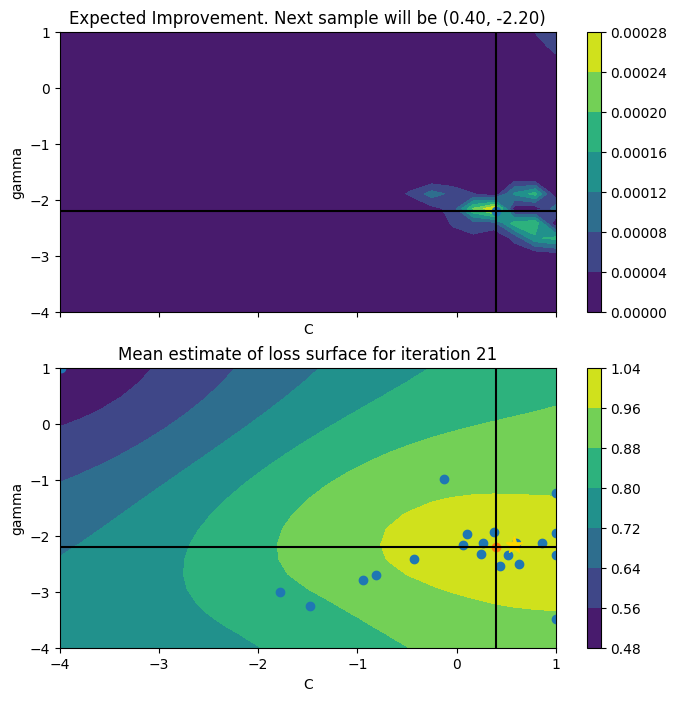

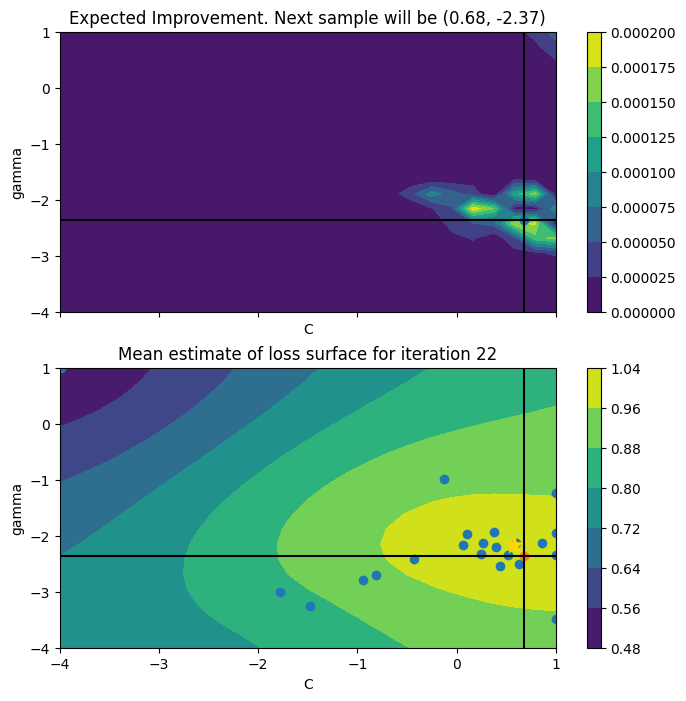

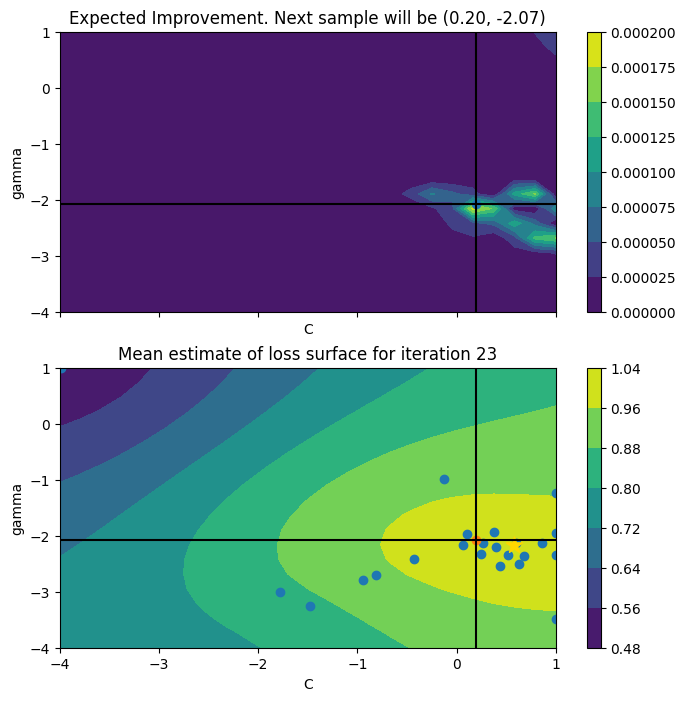

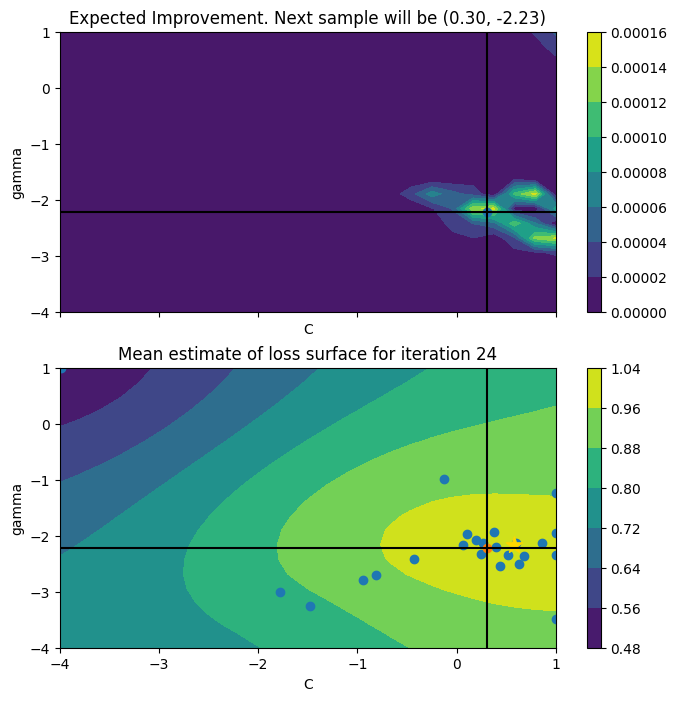

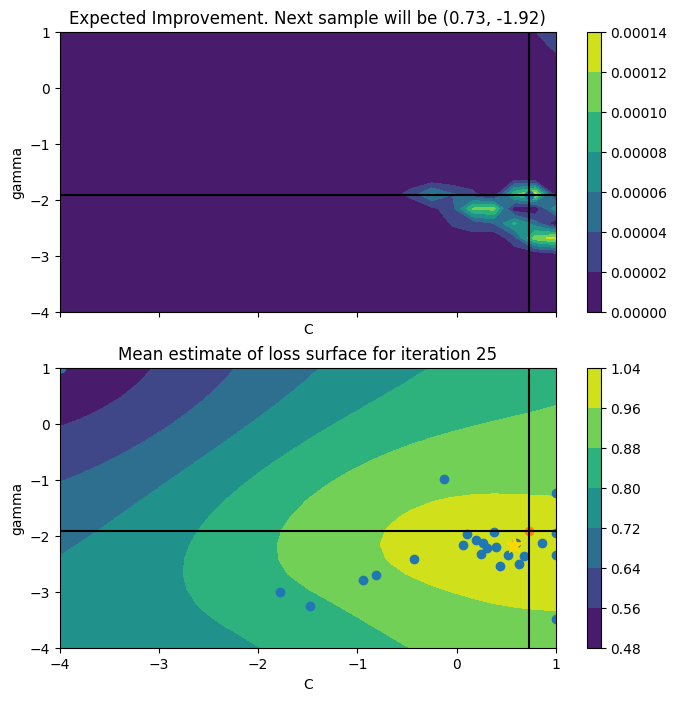

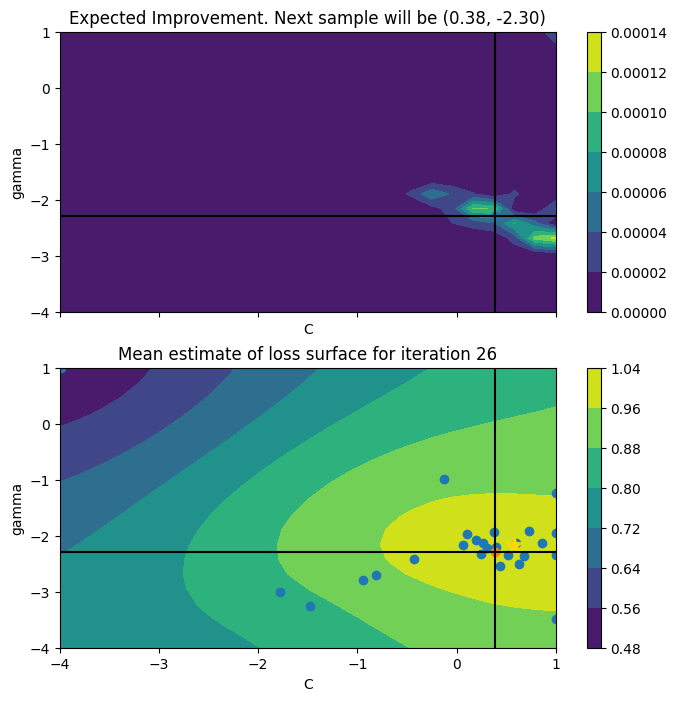

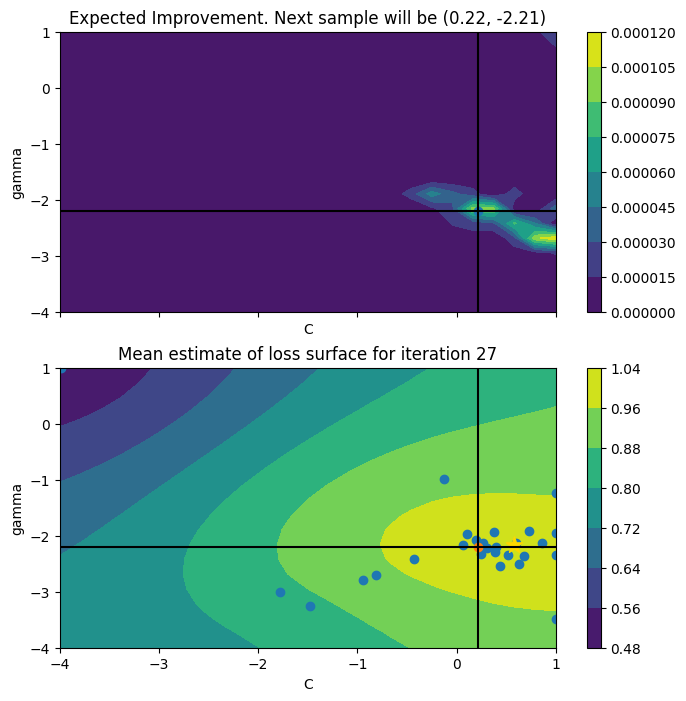

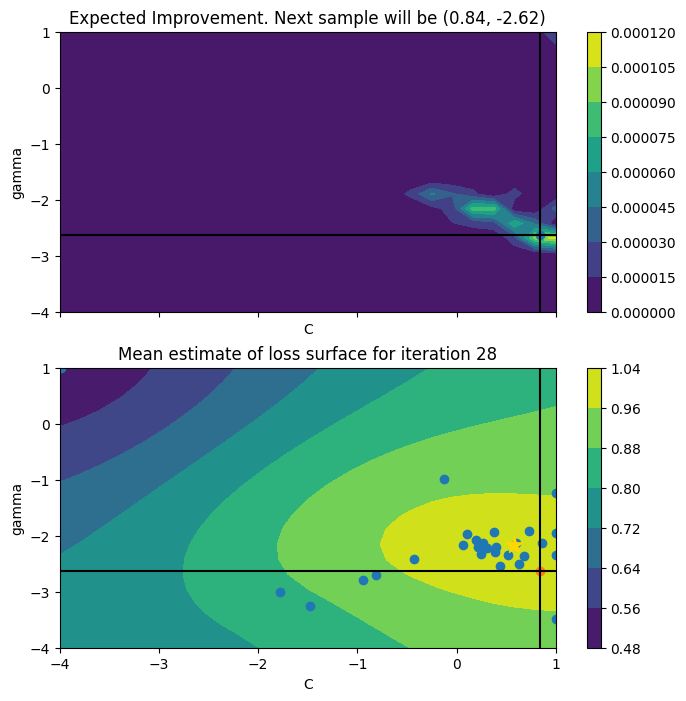

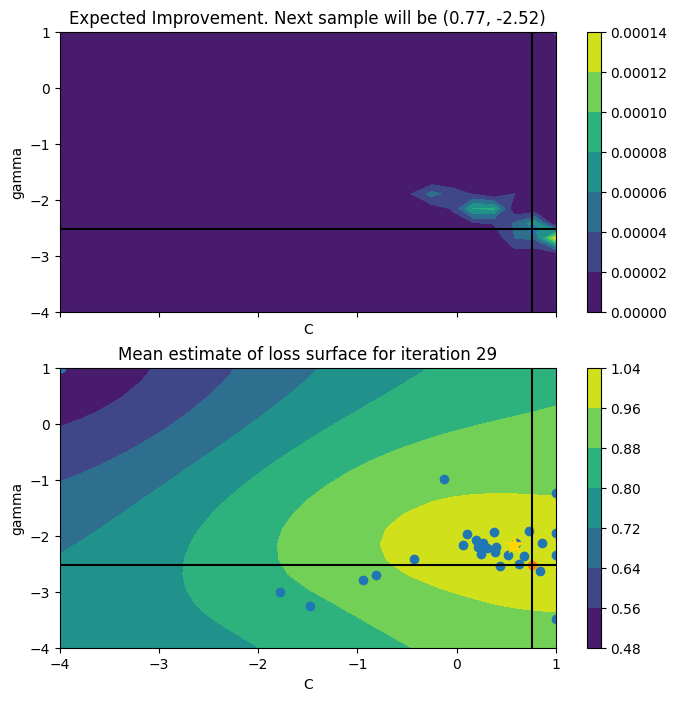

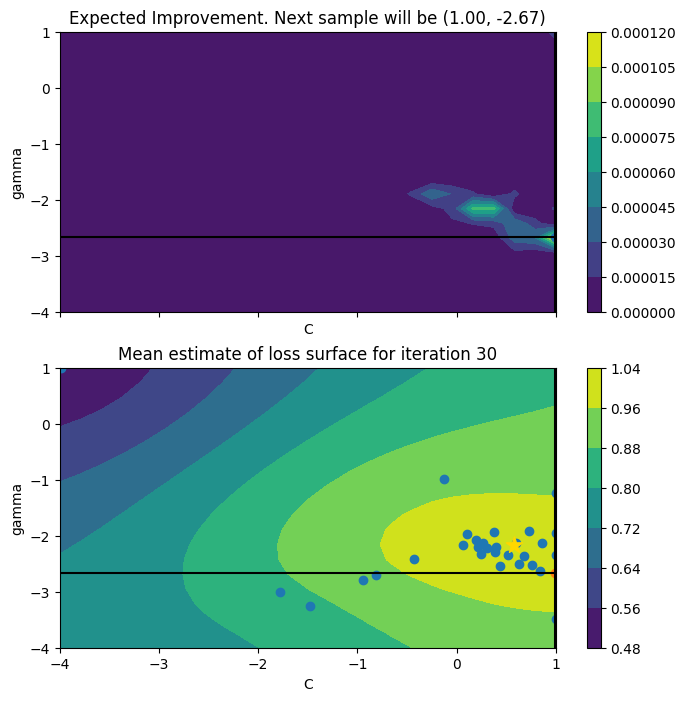

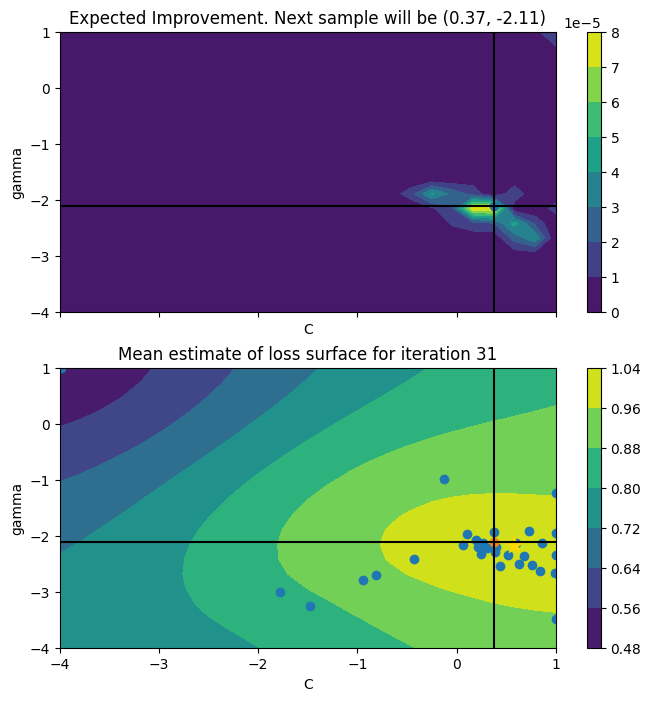

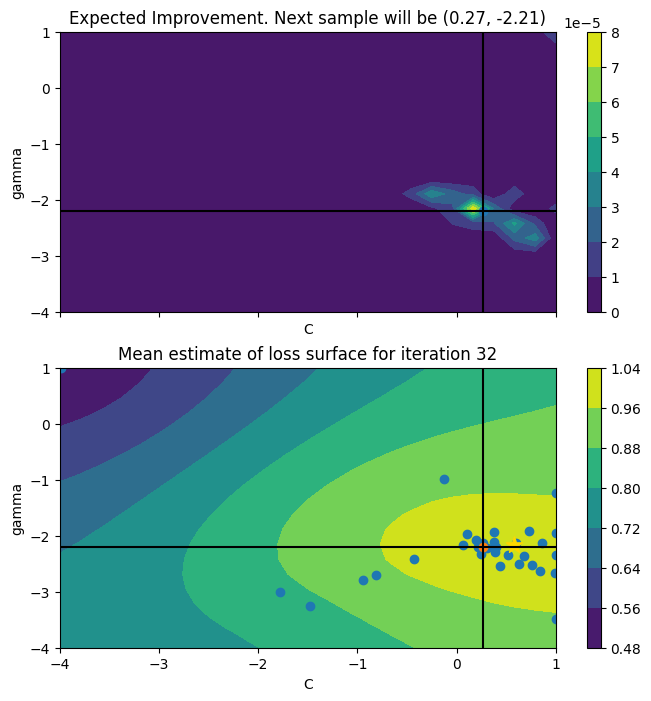

In [ ]:
rc('text', usetex=False)
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.58333333, -2.15789474])